In [1]:
import numpy as np
import nibabel
import nilearn
from nilearn.image import resample_to_img
import matplotlib.pyplot as plt
from nilearn import plotting
from nilearn.plotting import show
from nilearn.plotting import plot_roi
from nilearn import image
from nilearn.masking import apply_mask
# get_ipython().magic('matplotlib inline')
import scipy
import matplotlib
import matplotlib.pyplot as plt
from nilearn import image
from nilearn.input_data import NiftiMasker
#from nilearn import plotting
import nibabel
from nilearn.masking import apply_mask
from nilearn.image import load_img
from nilearn.image import new_img_like
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets, svm, metrics
from sklearn.linear_model import Ridge
from sklearn.svm import SVC, LinearSVC
from sklearn.cross_validation import KFold
from sklearn.cross_validation import LeaveOneLabelOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.feature_selection import SelectFwe
from scipy import signal
from scipy.fftpack import fft, fftshift
from scipy import interp

params = {'legend.fontsize': 'large',
          'figure.figsize': (5, 3),
          'axes.labelsize': 'x-large',
          'axes.titlesize': 'x-large',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large'}
font = {'weight': 'bold',
        'size': 22}
plt.rc('font', **font)
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectPercentile, f_classif, GenericUnivariateSelect, SelectKBest, chi2
from sklearn.feature_selection import RFE
import os
import seaborn as sns
import pandas as pd
import csv
from scipy import stats
import brainiak
import brainiak.funcalign.srm
import glob

/jukebox/pkgs/PYGER/beta/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/jukebox/pkgs/PYGER/beta/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
projectDir='/jukebox/norman/amennen/prettymouth_fmriprep2/'
DMNmask='/jukebox/norman/amennen/MNI_things/Yeo_JNeurophysiol11_MNI152/Yeo_Network7mask_reoriented_resampledBOLD.nii.gz'
fmriprep_dir=projectDir + '/derivatives/fmriprep'

In [3]:
# load subject numbers
subInd = 0
nsub=38
allnames = []
allgroups = []
groupInfo={}
# skip subjects 039 and 116
with open(projectDir + 'participants.tsv') as csvDataFile:
    csvReader = csv.reader(csvDataFile)
    for row in csvReader:
        if 'sub' in row[0]:
            # now skip the subjects we don't want to analyze
            allInfo = row[0].split('\t')
            subjName=allInfo[0]
            if subjName != 'sub-039' and subjName != 'sub-116':
                if allInfo[3] == 'paranoia':
                    group = 0
                elif allInfo[3] == 'affair':
                    group = 1
                allnames.append(subjName)
                allgroups.append(group)
                subInd+=1

In [4]:
paranoidSubj = allnames[0:19]
cheatingSubj = allnames[19:]
paranoidLabel = allgroups[0:19]
cheatingLabel = allgroups[19:]
nfolds=19
print(allnames)
segment_score_vector = np.load('segment_score_vector.npy')
beliefs_vector = np.load('beliefs_vector.npy')
emotions_vector = np.load('emotions_vector.npy')
intentions_vector = np.load('intentions_vector.npy')

['sub-088', 'sub-089', 'sub-090', 'sub-091', 'sub-092', 'sub-093', 'sub-094', 'sub-095', 'sub-096', 'sub-097', 'sub-098', 'sub-099', 'sub-100', 'sub-101', 'sub-102', 'sub-103', 'sub-104', 'sub-105', 'sub-106', 'sub-107', 'sub-108', 'sub-109', 'sub-110', 'sub-111', 'sub-068', 'sub-081', 'sub-112', 'sub-053', 'sub-113', 'sub-031', 'sub-114', 'sub-115', 'sub-117', 'sub-118', 'sub-119', 'sub-120', 'sub-121', 'sub-122']


In [5]:
# load results for specific case
ROI = 1
removeAvg = 1
filterType = 0
k1 = 0
k2 = 25
C_param = 1.0

# get upper right data
fn3 = glob.glob('new_bothphases/rtAtten_UPPER_RIGHT_winners_nofilter_predictproba_' + '_ROI_' + str(ROI) + '_AVGREMOVE_' + str(removeAvg)  + '_filter_' + str(filterType) + '_k1_' + str(k1) + '_k2_' + str(k2)  + '_perm_*.npz')
station_data3 = np.load(fn3[0]) # 58 x 1000 
orig_accuracy = station_data3['x']
orig_cheating_prob = station_data3['y']
orig_total_correct = station_data3['z']/2 # for proportions

fn3r = glob.glob('new_bothphases/rtAtten_UPPER_RIGHT_winners_nofilter_predictproba_no_replace' + '_ROI_' + str(ROI) + '_AVGREMOVE_' + str(removeAvg)  + '_filter_' + str(filterType) + '_k1_' + str(k1) + '_k2_' + str(k2)  + '_perm_*.npz')
station_data3r = np.load(fn3r[0]) # 58 x 1000 
orig_accuracyr = station_data3r['x']
orig_cheating_probr = station_data3r['y']
orig_total_correctr = station_data3r['z']/2 # for proportions


fn5 = glob.glob('logistic_test/rtAtten_UPPER_RIGHT_winners_nofilter' + '_ROI_' + str(ROI) + 'C_param' + str(C_param) + '_AVGREMOVE_' + str(removeAvg)  + '_filter_' + str(filterType) + '_k1_' + str(k1) + '_k2_' + str(k2)  + '_perm_*.npz')
station_data5 = np.load(fn5[0]) # 58 x 1000 
log_accuracy2 = station_data5['x']
log_cheating_prob2 = station_data5['y']
log_total_correct2 = station_data5['z']/2

fn5r = glob.glob('logistic_test/rtAtten_UPPER_RIGHT_winners_nofilter_no_replace' + '_ROI_' + str(ROI) + 'C_param' + str(C_param) + '_AVGREMOVE_' + str(removeAvg)  + '_filter_' + str(filterType) + '_k1_' + str(k1) + '_k2_' + str(k2)  + '_perm_*.npz')
station_data5r = np.load(fn5r[0]) # 58 x 1000 
log_accuracy2r = station_data5r['x']
log_cheating_prob2r = station_data5r['y']
log_total_correct2r = station_data5r['z']/2

# load station information
stationsDict3 = np.load('upper_right_winners_nofilter.npy',allow_pickle=True).item()
nStations3 = len(stationsDict3)


In [27]:
# new: 8/26: try to see ROC/AUC for each
np.shape(log_cheating_prob2) # 9 stations x 1000 reps x 2 
all_prob = np.concatenate((log_cheating_prob2r[:,:,0],log_cheating_prob2r[:,:,1]),axis=1)
correct_vals = np.array([1,0])
y = np.repeat(correct_vals,1000)
# calculate AUC for each iteration and for each station
AUC = np.zeros((9,))
for st in np.arange(9):
    this_prediction = all_prob[st,:]
    #fpr,tpr,_ = metrics.roc_curve(correct_vals,this_prediction)
    AUC[st] = metrics.roc_auc_score(y,this_prediction)

In [28]:
AUC

array([0.588096, 0.702395, 0.732194, 0.696045, 0.718033, 0.685187,
       0.779317, 0.881735, 0.792713])

In [26]:
orig_c_diff = orig_cheating_prob[:,:,0] - orig_cheating_prob[:,:,1]
log2_c_diff = log_cheating_prob2[:,:,0] - log_cheating_prob2[:,:,1]
orig_c_diffr = orig_cheating_probr[:,:,0] - orig_cheating_probr[:,:,1]
log2_c_diffr = log_cheating_prob2r[:,:,0] - log_cheating_prob2r[:,:,1]


In [10]:
np.mean(log2_c_diff,axis=1)

array([0.0896276 , 0.21968555, 0.25614196, 0.27615616, 0.22401892,
       0.19441683, 0.35782292, 0.53456556, 0.32205655])

(447,)
(1000, 447)
[25 26]
[61 62 63 64 65 66 67 68 69 70 71]
[111 112 113 114 115 116]
[177 178 179 180 181 182]
[282 283 284]
[303 304 305 306 307]
[345 346 347 348 349 350 351]
[376 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393
 394 395 396 397 398 399 400 401 402]
[428 429 430 431 432 433 434 435]


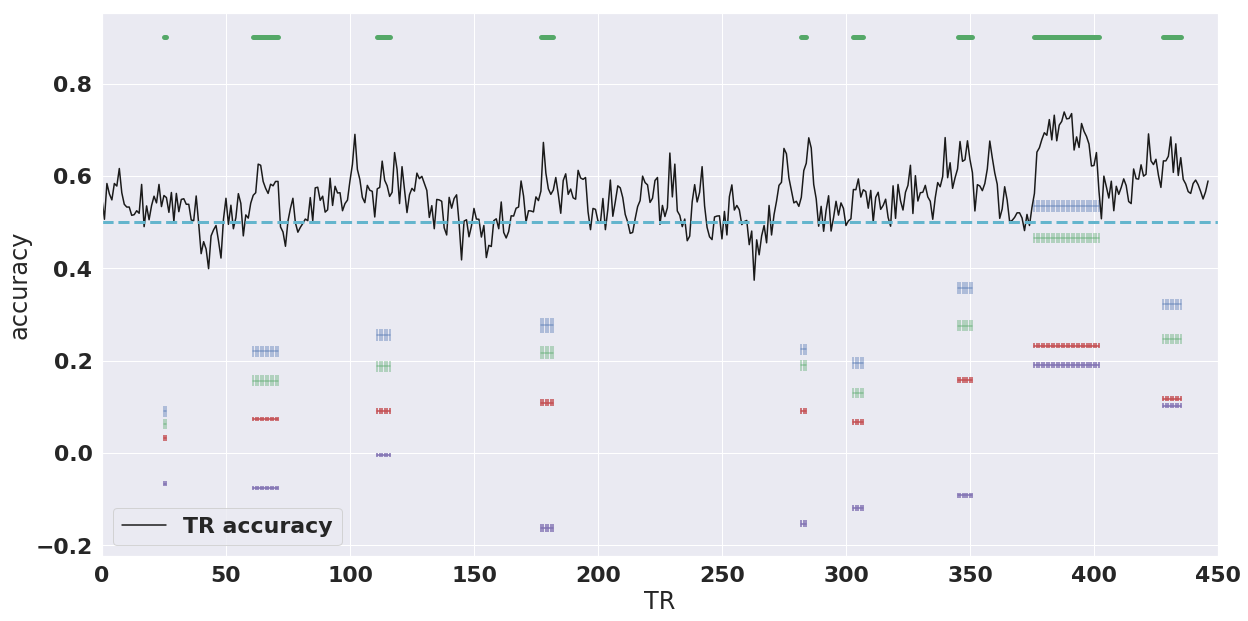

In [27]:
# load TR accuracy to plot in the same figure
classifierType=1
lowhigh=0
filename_data = glob.glob('new_bothphases/ARRAYDATA_BS_' + '_ROI_' + str(ROI) + '_AVGREMOVE_' + str(removeAvg) +  '_classifierType_' + str(classifierType) + '_filter_' + str(filterType) + '_lowhigh_' + str(lowhigh) + '_k1_' + str(k1) + '_k2_' + str(k2) + '_perm_*.npy')
#print(filename_data)
accuracy = np.load(filename_data[0]).T # this is 450 TRs x 1000 examples
nTR = np.shape(accuracy)[1]
np.mean(accuracy)
x = np.arange(nTR-3)
# changing for this plot--plot actual time points
y = accuracy[:,3:]
mean_acc = np.mean(y,axis=0)
all_station_err = scipy.stats.sem(orig_c_diff,axis=1,ddof=1)
all_station_err_log2 = scipy.stats.sem(log2_c_diff,axis=1,ddof=1)
all_station_errr = scipy.stats.sem(orig_c_diffr,axis=1,ddof=1)
all_station_err_log2r = scipy.stats.sem(log2_c_diffr,axis=1,ddof=1)



print(np.shape(x))
print(np.shape(y))
# make into dataframe: TR, accuracy
n_iter=1000
TR_vec = np.tile(x,n_iter)
data = y.flatten()

iter_number = np.repeat(np.arange(n_iter),nTR-3)
matrix = np.concatenate((TR_vec[:,np.newaxis],data[:,np.newaxis],iter_number[:,np.newaxis]),axis=1)
df = pd.DataFrame(data=matrix, columns = ['TR', 'accuracy','iter'])

sns.set(style="white")
sns.set(font_scale=2)
err_band = {}
err_band['alpha'] = 1
sem_acc = scipy.stats.sem(y)
plt.figure(figsize=(20,10))


# plot upper right stations
for st in np.arange(nStations3):
    this_station_TRs = np.array(stationsDict3[st])
    n_station_TRs = len(this_station_TRs)
    this_station_avg = np.mean(orig_c_diff[st,:])*np.ones((n_station_TRs,))
    # plot with error bars
    # put only one label
    plt.errorbar(this_station_TRs-3,this_station_avg,yerr=all_station_err[st],color='r', ecolor='r')

    
for st in np.arange(nStations3):
    this_station_TRs = np.array(stationsDict3[st])
    n_station_TRs = len(this_station_TRs)
    this_station_avg = np.mean(log2_c_diff[st,:])*np.ones((n_station_TRs,))
    # plot with error bars
    # put only one label
    plt.errorbar(this_station_TRs-3,this_station_avg,yerr=all_station_err_log2[st],color='g', ecolor='g',alpha=0.5)

for st in np.arange(nStations3):
    this_station_TRs = np.array(stationsDict3[st])
    n_station_TRs = len(this_station_TRs)
    this_station_avg = np.mean(orig_c_diffr[st,:])*np.ones((n_station_TRs,))
    # plot with error bars
    # put only one label
    plt.errorbar(this_station_TRs-3,this_station_avg,yerr=all_station_errr[st],color='m', ecolor='m')

for st in np.arange(nStations3):
    this_station_TRs = np.array(stationsDict3[st])
    n_station_TRs = len(this_station_TRs)
    this_station_avg = np.mean(log2_c_diffr[st,:])*np.ones((n_station_TRs,))
    # plot with error bars
    # put only one label
    plt.errorbar(this_station_TRs-3,this_station_avg,yerr=all_station_err_log2r[st],color='b', ecolor='b',alpha=0.5)
        
    
#sns.lineplot(x="TR",y="accuracy",color='b',data=df,ci=95,err_kws=err_band,label='real dist')
#plt.plot(segment_score_vector[0:-3]/10 + np.mean(y), '--', color='m', label='segment_score',linewidth=3)

plt.plot(x,np.mean(y,axis=0), color='k', label='TR accuracy')
#plt.plot(x,np.mean(y,axis=0), color='k', label='accuracy')
#plt.plot([0 ,500], [.6, .6], 'r--', lw=6)
plt.plot([0 ,500], [.5, .5], 'c--', lw=3)
#plt.ylim([0.8,1.05])
plt.xlabel('TR')
plt.ylabel('accuracy')
plt.xlim([0,nTR])

chosen2 = np.load('upper_right_winners_nofilter.npy').item()
for st in np.arange(len(chosen2)):
    station_TRs = np.array(chosen2[st]) - 3
    print(station_TRs)
    n_TRs = len(station_TRs)
    plt.plot(station_TRs,0.9*np.ones((n_TRs,)), lw=5, color='g', linestyle='-')
plt.legend()

# add: plot lines over chosen stations


In [12]:
c_prob_all = orig_cheating_prob[:,:,0]
p_prob_all = 1 - orig_cheating_prob[:,:,1]
orig_correct_prob = np.concatenate((c_prob_all,p_prob_all),axis=1)

# c_prob_l = log_cheating_prob[:,:,0]
# p_prob_l = 1 - log_cheating_prob[:,:,1]
# log_correct_prob = np.concatenate((c_prob_l,p_prob_l),axis=1)


c_prob_l2 = log_cheating_prob2[:,:,0]
p_prob_l2 = 1 - log_cheating_prob2[:,:,1]
log_correct_prob2 = np.concatenate((c_prob_l2,p_prob_l2),axis=1)

In [18]:
np.mean(orig_accuracy,axis=1)

array([0.593 , 0.645 , 0.6545, 0.662 , 0.647 , 0.6595, 0.721 , 0.832 ,
       0.711 ])

(447,)
(1000, 447)
[25 26]
[61 62 63 64 65 66 67 68 69 70 71]
[111 112 113 114 115 116]
[177 178 179 180 181 182]
[282 283 284]
[303 304 305 306 307]
[345 346 347 348 349 350 351]
[376 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393
 394 395 396 397 398 399 400 401 402]
[428 429 430 431 432 433 434 435]


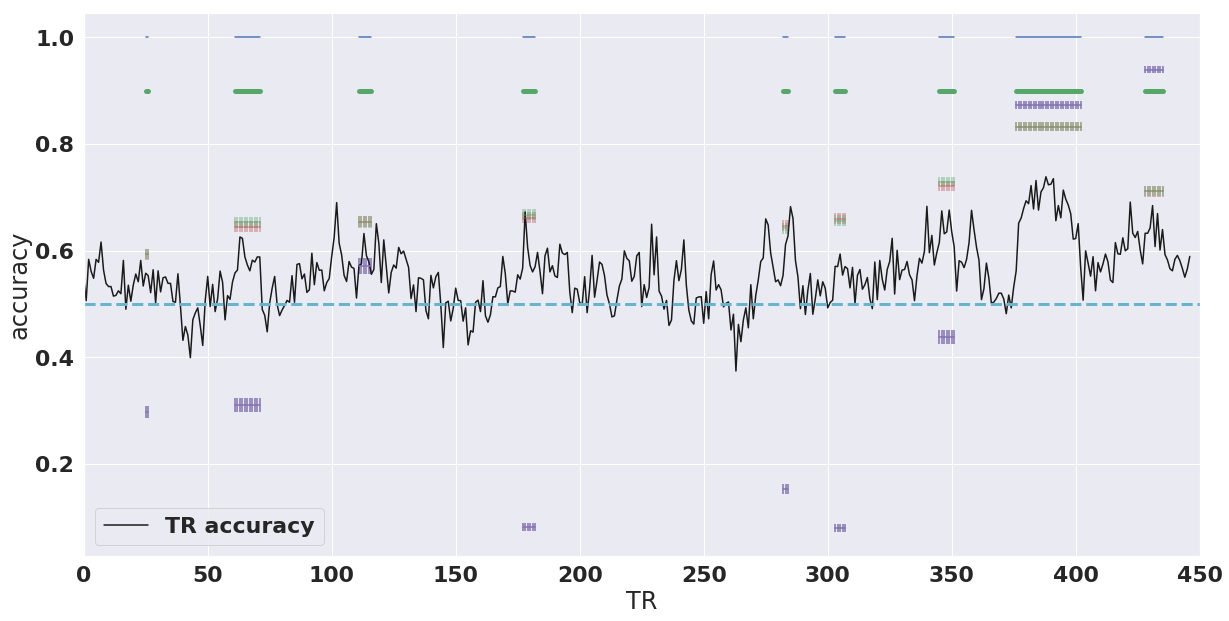

In [19]:
# load TR accuracy to plot in the same figure
classifierType=1
lowhigh=0
filename_data = glob.glob('new_bothphases/ARRAYDATA_BS_' + '_ROI_' + str(ROI) + '_AVGREMOVE_' + str(removeAvg) +  '_classifierType_' + str(classifierType) + '_filter_' + str(filterType) + '_lowhigh_' + str(lowhigh) + '_k1_' + str(k1) + '_k2_' + str(k2) + '_perm_*.npy')
#print(filename_data)
accuracy = np.load(filename_data[0]).T # this is 450 TRs x 1000 examples
nTR = np.shape(accuracy)[1]
np.mean(accuracy)
x = np.arange(nTR-3)
# changing for this plot--plot actual time points
y = accuracy[:,3:]
mean_acc = np.mean(y,axis=0)
all_station_err = scipy.stats.sem(orig_accuracy,axis=1,ddof=1)
#all_station_err_log = scipy.stats.sem(log_accuracy,axis=1,ddof=1)
all_station_err_log2 = scipy.stats.sem(log_accuracy2,axis=1,ddof=1)


total_corr_err = scipy.stats.sem(orig_total_correct,axis=1,ddof=1)
#total_cor_err_log = scipy.stats.sem(log_total_correct,axis=1,ddof=1)
total_corr_err_log2 = scipy.stats.sem(log_total_correct2,axis=1,ddof=1)

print(np.shape(x))
print(np.shape(y))
# make into dataframe: TR, accuracy
n_iter=1000
TR_vec = np.tile(x,n_iter)
data = y.flatten()

iter_number = np.repeat(np.arange(n_iter),nTR-3)
matrix = np.concatenate((TR_vec[:,np.newaxis],data[:,np.newaxis],iter_number[:,np.newaxis]),axis=1)
df = pd.DataFrame(data=matrix, columns = ['TR', 'accuracy','iter'])

sns.set(style="white")
sns.set(font_scale=2)
err_band = {}
err_band['alpha'] = 1
sem_acc = scipy.stats.sem(y)
plt.figure(figsize=(20,10))


# plot upper right stations
for st in np.arange(nStations3):
    this_station_TRs = np.array(stationsDict3[st])
    n_station_TRs = len(this_station_TRs)
    this_station_avg = np.mean(orig_accuracy[st,:])*np.ones((n_station_TRs,))
    # plot with error bars
    # put only one label
    plt.errorbar(this_station_TRs-3,this_station_avg,yerr=all_station_err[st],color='r', ecolor='r',alpha=0.5)
    avg_total_correct = np.mean(orig_total_correct[st,:])*np.ones((n_station_TRs))
    plt.errorbar(this_station_TRs-3,avg_total_correct,yerr=total_corr_err[st],color='m', ecolor='m')

    
# for st in np.arange(nStations3):
#     this_station_TRs = np.array(stationsDict3[st])
#     n_station_TRs = len(this_station_TRs)
#     this_station_avg = np.mean(log_accuracy[st,:])*np.ones((n_station_TRs,))
#     # plot with error bars
#     # put only one label
#     plt.errorbar(this_station_TRs-3,this_station_avg,yerr=all_station_err_log[st],color='b', ecolor='b')
    
for st in np.arange(nStations3):
    this_station_TRs = np.array(stationsDict3[st])
    n_station_TRs = len(this_station_TRs)
    this_station_avg = np.mean(log_accuracy2[st,:])*np.ones((n_station_TRs,))
    # plot with error bars
    # put only one label
    plt.errorbar(this_station_TRs-3,this_station_avg,yerr=all_station_err_log2[st],color='g', ecolor='g',alpha=0.5)
    avg_total_correct = np.mean(log_total_correct2[st,:])*np.ones((n_station_TRs))
    plt.errorbar(this_station_TRs-3,avg_total_correct,yerr=total_corr_err_log2[st],color='b', ecolor='b')

    
    
#sns.lineplot(x="TR",y="accuracy",color='b',data=df,ci=95,err_kws=err_band,label='real dist')
#plt.plot(segment_score_vector[0:-3]/10 + np.mean(y), '--', color='m', label='segment_score',linewidth=3)

plt.plot(x,np.mean(y,axis=0), color='k', label='TR accuracy')
#plt.plot(x,np.mean(y,axis=0), color='k', label='accuracy')
#plt.plot([0 ,500], [.6, .6], 'r--', lw=6)
plt.plot([0 ,500], [.5, .5], 'c--', lw=3)
#plt.ylim([0.8,1.05])
plt.xlabel('TR')
plt.ylabel('accuracy')
plt.xlim([0,nTR])

chosen2 = np.load('upper_right_winners_nofilter.npy').item()
for st in np.arange(len(chosen2)):
    station_TRs = np.array(chosen2[st]) - 3
    print(station_TRs)
    n_TRs = len(station_TRs)
    plt.plot(station_TRs,0.9*np.ones((n_TRs,)), lw=5, color='g', linestyle='-')
plt.legend()

# add: plot lines over chosen stations


In [14]:
# load TR accuracy to plot in the same figure
classifierType=1
lowhigh=0
filename_data = glob.glob('new_bothphases/ARRAYDATA_BS_' + '_ROI_' + str(ROI) + '_AVGREMOVE_' + str(removeAvg) +  '_classifierType_' + str(classifierType) + '_filter_' + str(filterType) + '_lowhigh_' + str(lowhigh) + '_k1_' + str(k1) + '_k2_' + str(k2) + '_perm_*.npy')
#print(filename_data)
accuracy = np.load(filename_data[0]).T # this is 450 TRs x 1000 examples
nTR = np.shape(accuracy)[1]
np.mean(accuracy)
x = np.arange(nTR-3)
# changing for this plot--plot actual time points
y = accuracy[:,3:]
mean_acc = np.mean(y,axis=0)
all_station_err = scipy.stats.sem(orig_correct_prob,axis=1,ddof=1)
all_station_err_log = scipy.stats.sem(log_correct_prob,axis=1,ddof=1)
all_station_err_log2 = scipy.stats.sem(log_correct_prob2,axis=1,ddof=1)


print(np.shape(x))
print(np.shape(y))
# make into dataframe: TR, accuracy
n_iter=1000
TR_vec = np.tile(x,n_iter)
data = y.flatten()

iter_number = np.repeat(np.arange(n_iter),nTR-3)
matrix = np.concatenate((TR_vec[:,np.newaxis],data[:,np.newaxis],iter_number[:,np.newaxis]),axis=1)
df = pd.DataFrame(data=matrix, columns = ['TR', 'accuracy','iter'])

sns.set(style="white")
sns.set(font_scale=2)
err_band = {}
err_band['alpha'] = 1
sem_acc = scipy.stats.sem(y)
plt.figure(figsize=(20,10))


# plot upper right stations
for st in np.arange(nStations3):
    this_station_TRs = np.array(stationsDict3[st])
    n_station_TRs = len(this_station_TRs)
    this_station_avg = np.mean(orig_correct_prob[st,:])*np.ones((n_station_TRs,))
    # plot with error bars
    # put only one label
    plt.errorbar(this_station_TRs-3,this_station_avg,yerr=all_station_err[st],color='r', ecolor='r')
    
# for st in np.arange(nStations3):
#     this_station_TRs = np.array(stationsDict3[st])
#     n_station_TRs = len(this_station_TRs)
#     this_station_avg = np.mean(log_correct_prob[st,:])*np.ones((n_station_TRs,))
#     # plot with error bars
#     # put only one label
#     plt.errorbar(this_station_TRs-3,this_station_avg,yerr=all_station_err_log[st],color='b', ecolor='b')

for st in np.arange(nStations3):
    this_station_TRs = np.array(stationsDict3[st])
    n_station_TRs = len(this_station_TRs)
    this_station_avg = np.mean(log_correct_prob2[st,:])*np.ones((n_station_TRs,))
    # plot with error bars
    # put only one label
    plt.errorbar(this_station_TRs-3,this_station_avg,yerr=all_station_err_log2[st],color='g', ecolor='g')
    
    
#sns.lineplot(x="TR",y="accuracy",color='b',data=df,ci=95,err_kws=err_band,label='real dist')
#plt.plot(segment_score_vector[0:-3]/10 + np.mean(y), '--', color='m', label='segment_score',linewidth=3)

plt.plot(x,np.mean(y,axis=0), color='k', label='TR accuracy')
#plt.plot(x,np.mean(y,axis=0), color='k', label='accuracy')
#plt.plot([0 ,500], [.6, .6], 'r--', lw=6)
plt.plot([0 ,500], [.5, .5], 'c--', lw=3)
plt.ylim([0.4,1.05])
plt.xlabel('TR')
plt.ylabel('probability')
plt.xlim([0,nTR])

chosen2 = np.load('upper_right_winners_nofilter.npy').item()
for st in np.arange(len(chosen2)):
    station_TRs = np.array(chosen2[st]) - 3
    print(station_TRs)
    n_TRs = len(station_TRs)
    plt.plot(station_TRs,0.9*np.ones((n_TRs,)), lw=5, color='g', linestyle='-')
plt.legend()

# add: plot lines over chosen stations


NameError: name 'log_correct_prob' is not defined

In [15]:
sns.set(style="white")

# NEW -- just plot accuracy
# load TR accuracy to plot in the same figure
classifierType=1
lowhigh=0
filename_data = glob.glob('new_bothphases/ARRAYDATA_BS_' + '_ROI_' + str(ROI) + '_AVGREMOVE_' + str(removeAvg) +  '_classifierType_' + str(classifierType) + '_filter_' + str(filterType) + '_lowhigh_' + str(lowhigh) + '_k1_' + str(k1) + '_k2_' + str(k2) + '_perm_*.npy')
#print(filename_data)
accuracy = np.load(filename_data[0]).T # this is 450 TRs x 1000 examples
nTR = np.shape(accuracy)[1]
np.mean(accuracy)
x = np.arange(nTR-3)
# changing for this plot--plot actual time points
y = accuracy[:,3:]
mean_acc = np.mean(y,axis=0)
all_station_err = scipy.stats.sem(final_station_data,axis=1,ddof=1)


print(np.shape(x))
print(np.shape(y))
# make into dataframe: TR, accuracy
n_iter=1000
TR_vec = np.tile(x,n_iter)
data = y.flatten()

iter_number = np.repeat(np.arange(n_iter),nTR-3)
matrix = np.concatenate((TR_vec[:,np.newaxis],data[:,np.newaxis],iter_number[:,np.newaxis]),axis=1)
df = pd.DataFrame(data=matrix, columns = ['TR', 'accuracy','iter'])

sns.set(font_scale=2)
err_band = {}
err_band['alpha'] = 1
sem_acc = scipy.stats.sem(y)
plt.figure(figsize=(20,10))


# plot upper right stations
for st in np.arange(nStations3):
    this_station_TRs = np.array(stationsDict3[st])
    n_station_TRs = len(this_station_TRs)
    this_station_avg = np.mean(station_data3[st,:])*np.ones((n_station_TRs,))
    # plot with error bars
    # put only one label
    plt.errorbar(this_station_TRs-3,this_station_avg,yerr=all_station_err[st],color='r', ecolor='r')
    
 
plt.plot(x,np.mean(y,axis=0), color='k', label='TR accuracy')
#plt.plot(x,np.mean(y,axis=0), color='k', label='accuracy')
#plt.plot([0 ,500], [.6, .6], 'r--', lw=6)
plt.plot([0 ,500], [.5, .5], 'c--', lw=3)
plt.ylim([0,1])
plt.xlabel('TR')
plt.ylabel('accuracy')
plt.xlim([0,nTR])

chosen2 = np.load('upper_right_winners_nofilter.npy').item()
for st in np.arange(len(chosen)):
    station_TRs = np.array(chosen2[st]) - 3
    print(station_TRs)
    n_TRs = len(station_TRs)
    plt.plot(station_TRs,0.9*np.ones((n_TRs,)), lw=5, color='g', linestyle='-')
plt.legend()

# add: plot lines over chosen stations


NameError: name 'final_station_data' is not defined

In [31]:
np.shape(final_station_data)
# choden indices
keep_indices = [1,25,4,6,10,11,21,15,24]

station_accuracy_chosen = station_data3[keep_indices,:]
station_average_accuracy = np.mean(station_accuracy_chosen,axis=1)
station_average_accuracy
station_order = np.argsort(station_average_accuracy)[::-1]
print(np.argsort(station_average_accuracy)[::-1])
print(station_average_accuracy[station_order])

[7 6 8 3 1 5 4 2 0]
[0.778  0.6885 0.662  0.645  0.607  0.6055 0.6055 0.5955 0.5715]


In [14]:
# new as of 4/17 make new station dictionary combining upper right and mega search
upper_right_winners = {}
keep_indices = [1,25,4,6,10,11,21,15,24]
n_keep = len(keep_indices)
for s in np.arange(n_keep):
    upper_right_winners[s] = stationsDict3[keep_indices[s]]
np.save('upper_right_winners_nofilter.npy', upper_right_winners)

mega_winners = {}
keep_indices = [1,2,7,11,15,22,23,28,30,33]
for s in np.arange(n_keep):
    mega_winners[s] = stationsDict[keep_indices[s]]
np.save('mega_winners_nofilter.npy',mega_winners)

In [15]:
mega_winners

{0: [31, 32, 33, 34, 35, 36],
 1: [64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74],
 2: [114, 115, 116, 117, 118, 119, 120, 121, 122],
 3: [180, 181, 182, 183, 184, 185, 186, 187],
 4: [225, 226, 227],
 5: [285, 286, 287, 288, 289, 290, 291],
 6: [306, 307, 308, 309, 310, 311],
 7: [339,
  340,
  341,
  342,
  343,
  344,
  345,
  346,
  347,
  348,
  349,
  350,
  351,
  352,
  353,
  354],
 8: [379,
  380,
  381,
  382,
  383,
  384,
  385,
  386,
  387,
  388,
  389,
  390,
  391,
  392,
  393,
  394,
  395,
  396,
  397,
  398,
  399,
  400,
  401,
  402,
  403,
  404,
  405]}

In [8]:
z = np.load('upper_right_winners_nofilter.npy')
# this is the stations we''re using

In [9]:
z

array({0: [28, 29], 1: [64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74], 2: [114, 115, 116, 117, 118, 119], 3: [180, 181, 182, 183, 184, 185], 4: [285, 286, 287], 5: [306, 307, 308, 309, 310], 6: [348, 349, 350, 351, 352, 353, 354], 7: [379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405], 8: [431, 432, 433, 434, 435, 436, 437, 438]},
      dtype=object)